## Welcome To The Tutorial 4 Of Responsible AI

#### Welcome to our tutorial on Pre-processing based approach to mitigate discrimination in Machine Learning

In this tutorial, we explore popular pre-processing based fairness methods and provide practical code examples using the ACS-PUMS data to mitigate bias in machine learning models.


**Preprocessing methods** in the context of fairness in machine learning refer to techniques applied to the dataset before it is used to train a model. These methods aim to mitigate bias and ensure that the model treats different groups fairly. Here are some common preprocessing fairness methods:

**1) Sampling Techniques:**
Oversampling or undersampling can be employed to balance the number of instances across different groups. This helps in reducing the impact of imbalanced representation, ensuring that all groups are adequately represented in the training data.

**2) Feature Engineering:**
Create new features or modify existing ones to eliminate or reduce bias. For example, you might derive features that represent the relationship between sensitive attributes and the target variable in a less biased manner.

**3) Reweighting Instances:**
Adjust the weights of instances in the training data to balance the contribution of different groups. This can be done by assigning higher weights to underrepresented groups or samples to ensure that the model pays equal attention to all groups.

#### Lets dive into more details by training an ML model on previously introduced ACS-PUMS data 

For practice we will resume with our own defined task and filter using the folktables library

In [1]:
import folktables
from folktables import ACSDataSource

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AR"], download=True)

In [56]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,f1_score
import numpy as np
from fairlearn.metrics import true_positive_rate

#### Defining our own filter

In [3]:
def our_filter(data):
    df = data
    df = df[df['AGEP'] < 65]
    df = df[df['PINCP'] > 1000]
    df = df[df['WKHP'] > 2]
    df = df[df['PWGTP'] >= 1]
    return df

#### Defining our own task

In [4]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','RAC1P','PUMA', 'OCCP','JWTR','GCL','PINCP',
        'ESR', 'OCCP', 'POWPUMA']

Hardworkers = folktables.BasicProblem(
                         features=features,
                        target='WKHP',
                        target_transform=lambda x: x > 45,
                        group='SEX',
                        preprocess=our_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [110]:
features, label, group = Hardworkers.df_to_pandas(acs_data)

In [111]:
group

,SEX
0,2
1,1
2,2
3,2
4,2
...,...
12430,1
12431,1
12432,2
12433,2


#### 1: Male, 2: Female (refer to tutorial 2)

In [112]:
male_dist=label['WKHP'][group['SEX']==1]
female_dist=label['WKHP'][group['SEX']==2]

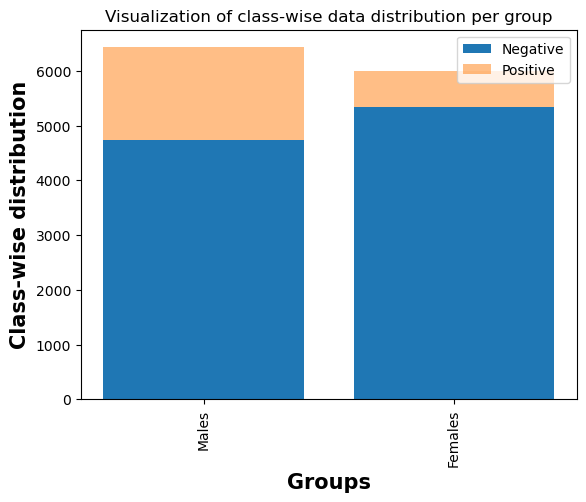

In [113]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Males','Females']

# Create a list to store the cumulative values
cumulative_values = np.array([[sum(male_dist==True),sum(male_dist==False)],
                              [sum(female_dist==True),sum(female_dist==False)]])

# Create the cumulative bar plot with current values on top of previous values
plt.bar(categories, cumulative_values[:,1], label='Negative')
plt.bar(categories, cumulative_values[:,0], label='Positive', bottom=cumulative_values[:,1], alpha=0.5)

# Add labels and a legend
plt.xlabel('Groups',fontsize=15,weight='bold')
plt.xticks(categories,rotation=90)
plt.ylabel('Class-wise distribution',fontsize=15,weight='bold')
plt.title('Visualization of class-wise data distribution per group')
plt.legend()

plt.show()

**Notice** the clear imbalance against the female population


**1) Sampling Techniques:**

- Undersmapling majority
- Oversampling minority

**Oversampling:**

**Definition:** Increase minority group representation by adding more instances of the underrepresented class to the training dataset.

**Fairness Application:** Specifically boost instances from disadvantaged groups for fairer model predictions.

**Considerations:** Be cautious of synthetic oversampling techniques, and monitor for potential overfitting.


**Undersampling:**

**Definition:** Reduce majority group representation by randomly removing instances from the overrepresented class in the training dataset.

**Fairness Application:** Target majority groups that may have historically received preferential treatment to encourage fairer model outcomes.

**Considerations:** Strive for a balance between addressing bias and maintaining representative information.
Combined Oversampling and Undersampling:

Techniques like SMOTE-ENN can be used to oversample the minority class and undersample the majority class for a more balanced and fair dataset.

# 


We will use the library imblearn

It is super easy to install: pip install imblearn 

##### Imblance learn library has some issues with sklearn version avove 1.2.1, so remember to downgrade sklearn to version 1.2.1

In [114]:
from imblearn.over_sampling import RandomOverSampler 

In [115]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

#### We will sample based on minority group, but don't want to loose the class distribution information while new generating samples

In [116]:
X_train['Class']=y_train.copy()

In [117]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, group_over = oversample.fit_resample(X_train,group_train)

In [118]:
y_train=X_over['Class'].copy()

In [119]:
X_train=X_over.drop(columns=['Class']).copy()

#### Let's visualize how our sampling strategy impacted our train data distribution

In [120]:
male_dist=y_train[group_over['SEX']==1]
female_dist=y_train[group_over['SEX']==2]

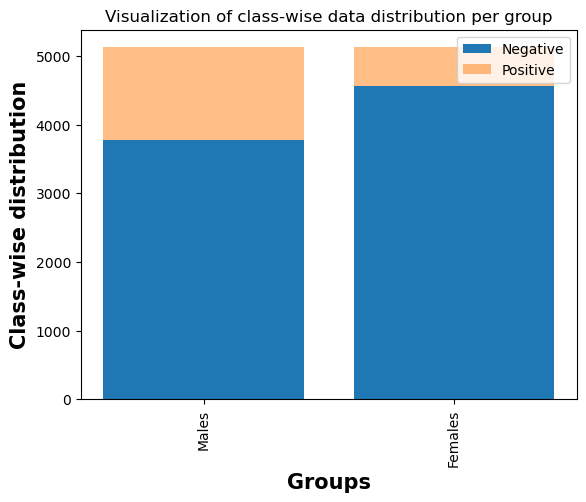

In [121]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Males','Females']

# Create a list to store the cumulative values
cumulative_values = np.array([[sum(male_dist==True),sum(male_dist==False)],
                              [sum(female_dist==True),sum(female_dist==False)]])

# Create the cumulative bar plot with current values on top of previous values
plt.bar(categories, cumulative_values[:,1], label='Negative')
plt.bar(categories, cumulative_values[:,0], label='Positive', bottom=cumulative_values[:,1], alpha=0.5)

# Add labels and a legend
plt.xlabel('Groups',fontsize=15,weight='bold')
plt.xticks(categories,rotation=90)
plt.ylabel('Class-wise distribution',fontsize=15,weight='bold')
plt.title('Visualization of class-wise data distribution per group')
plt.legend()

plt.show()

### We have almost equal data for males and females, but can you still spot the difference?? 
let's see how our model, the same basic one that we used in our earlier tutorials, learns with this new data distribution

In [122]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

## 

#### We begin by accessing the models performance on each group using some commonly used ML evaluation metrics

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'precision'}, ylabel='SEX'>,
        <Axes: title={'center': 'F1 score'}, ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

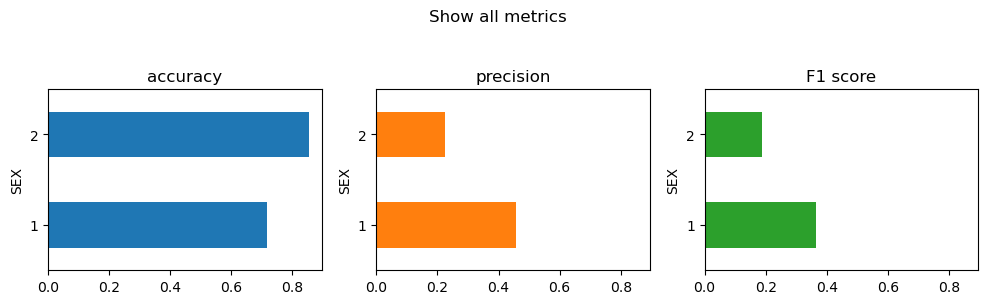

In [123]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "F1 score": f1_score,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

**Let's evaluate using the popular fairness measures in machine learning, introduced in the last tutorial**

### 1. Statistical Parity (Disparate Impact):


2487
1303
1184


array([[<Axes: title={'center': 'Positive Predictions'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

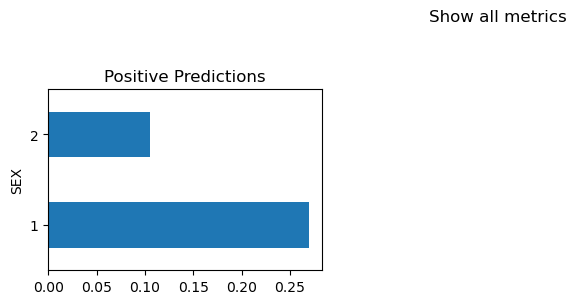

In [124]:
def pos_pred(y,g):
    print(len(g))
    return sum(y==True)/len(g)

metrics = {
    "Positive Predictions": pos_pred
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### 2. Equal Opportunity (True Positive Parity):

array([[<Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

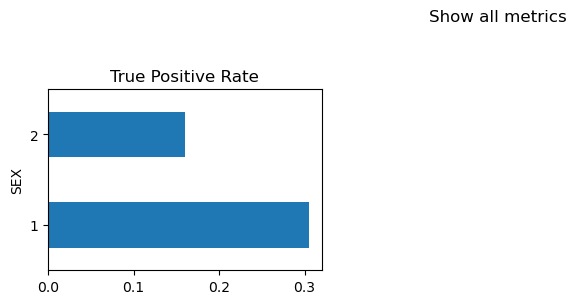

In [125]:
metrics = {
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

####  So based on our above observations the model learns very few positive predictions and very bad positive in identifying true positive predictions for females. 

The question is how can we improve it?? Let's start again and do oversampling, but this time based on bothy group and class

In [126]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [127]:
X_train['Class']=y_train.copy()
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, group_over = oversample.fit_resample(X_train,group_train)
y_train=X_over['Class'].copy()
X_train=X_over.drop(columns=['Class']).copy()
X_train['group']=group_over.copy()
X_over, y_train = oversample.fit_resample(X_train,y_train)
group_train=X_over['group'].copy()
X_train=X_over.drop(columns=['group']).copy()

In [128]:
male_dist=y_train[group_train==1]
female_dist=y_train[group_train==2]

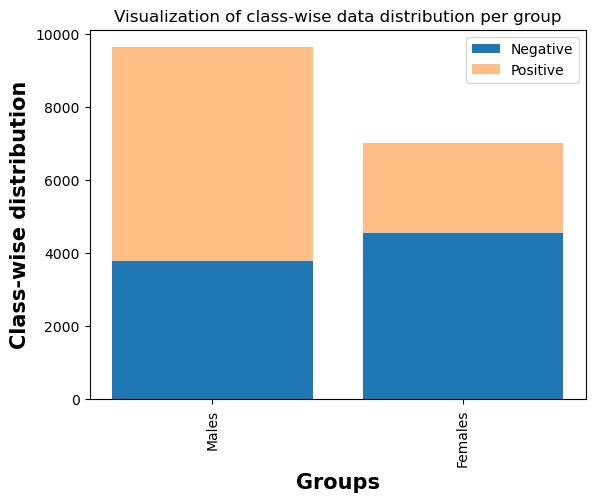

In [129]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Males','Females']

# Create a list to store the cumulative values
cumulative_values = np.array([[sum(male_dist==True),sum(male_dist==False)],
                              [sum(female_dist==True),sum(female_dist==False)]])

# Create the cumulative bar plot with current values on top of previous values
plt.bar(categories, cumulative_values[:,1], label='Negative')
plt.bar(categories, cumulative_values[:,0], label='Positive', bottom=cumulative_values[:,1], alpha=0.5)

# Add labels and a legend
plt.xlabel('Groups',fontsize=15,weight='bold')
plt.xticks(categories,rotation=90)
plt.ylabel('Class-wise distribution',fontsize=15,weight='bold')
plt.title('Visualization of class-wise data distribution per group')
plt.legend()

plt.show()

In [130]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

2487
1303
1184


array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'Positive Predictions'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

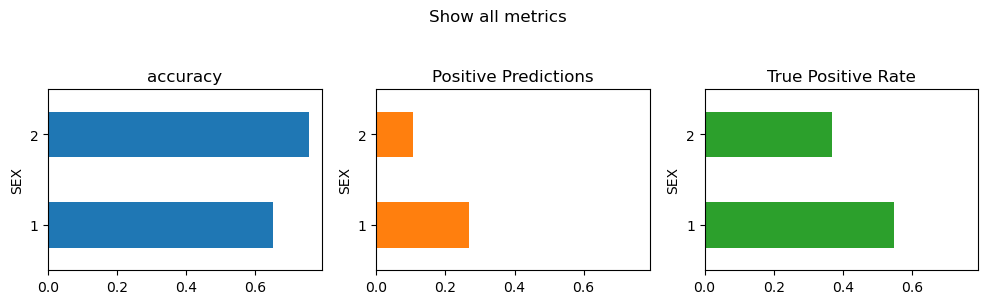

In [131]:
metrics = {
    "accuracy": accuracy_score,
    "Positive Predictions": pos_pred,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

#### What do you think? Did we improved?? What else we can do in terms of sampling?? Try implementing Undersampling of majority by yourself and check the results.

 **Hint**: within the imblearn.under_sampling library you will find various methods

## 
Before moving on the next part let's try some synthetic sampling techniques (generating sythetic samples of minority) that also combines undersampling of majority. We will look into a specfic algorithm called SMOTE-ENN.


**SMOTE-ENN** or Synthetic Minority Over-sampling Technique with Edited Nearest Neighbors, is a combination of two techniques: SMOTE (Synthetic Minority Over-sampling Technique) and ENN (Edited Nearest Neighbors). These techniques are used in the context of imbalanced datasets to address the issue of minority class under-representation.

In [132]:
from imblearn.combine import SMOTEENN

In [133]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

X_train['Class']=y_train.copy()

We saw previously that the main problem is underrepresentation of females in the positive class. So this time we will try to specifically only oversample the positive females. To do so we will need another binary valued array where only the positive females are marked as 1 and rest as 0. 

In [134]:
X_train['sex']=group_train.copy()
group_minor=(group_train['SEX']==2) * (y_train['WKHP']==True)

In [135]:
smotenn=SMOTEENN()
X_over,_= smotenn.fit_resample(X_train,np.array(group_minor))

In [136]:
group_train=X_over['sex'].copy()
y_train=X_over['Class'].copy()

X_train=X_over.drop(columns=['Class','sex']).copy()

Let's visualize how the sampling affected our data distribution

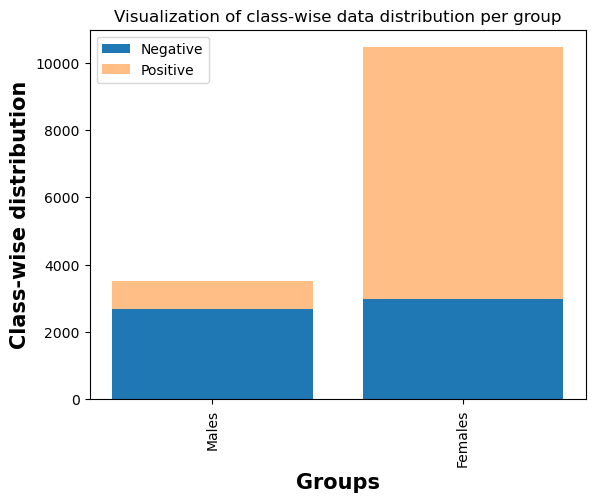

In [137]:
male_dist=y_train[group_train==1]
female_dist=y_train[group_train==2]

import matplotlib.pyplot as plt

# Sample data
categories = ['Males','Females']

# Create a list to store the cumulative values
cumulative_values = np.array([[sum(male_dist==True),sum(male_dist==False)],
                              [sum(female_dist==True),sum(female_dist==False)]])

# Create the cumulative bar plot with current values on top of previous values
plt.bar(categories, cumulative_values[:,1], label='Negative')
plt.bar(categories, cumulative_values[:,0], label='Positive', bottom=cumulative_values[:,1], alpha=0.5)

# Add labels and a legend
plt.xlabel('Groups',fontsize=15,weight='bold')
plt.xticks(categories,rotation=90)
plt.ylabel('Class-wise distribution',fontsize=15,weight='bold')
plt.title('Visualization of class-wise data distribution per group')
plt.legend()

plt.show()

So now we have completely changed the minority into a mojority. Let's see how it impacts our classifier.

In [138]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

2487
1303
1184


array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'Positive Predictions'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

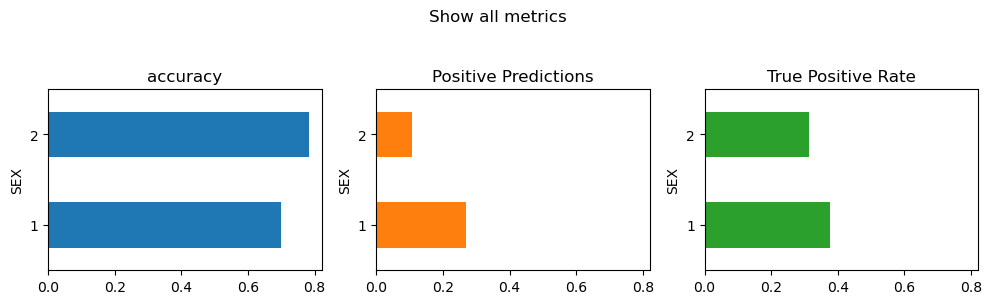

In [139]:
metrics = {
    "accuracy": accuracy_score,
    "Positive Predictions": pos_pred,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

We can see that even though we changed the training distribution of the data completely in favour of the minority, but still our classifier is struggling to learn good predictions for the protected group 'Females' in the minority positive class. This indicates the bias still remains in the system through the biased feature distrubution.

**2) Feature Engineering:**
Feature engineering is a crucial aspect of preprocessing in machine learning, and when it comes to fairness, thoughtful feature engineering can help mitigate bias and ensure equitable treatment of different groups. We will look into a couple of feature engineering-based preprocessing techniques for fairness:

- Proxy Feature Removal
-  Fair Representations

**Proxy Feature Removal:** The Fairlearn library has a preprocessing method called the correlation remover. This is a very nice example of feature engineering for Proxy Feature Removal technique. We already saw the implementation of that method in our tutorial 1. 



**Fair Representations:** Fair representation learning refers to the process of learning a data representation that captures essential features and patterns while minimizing the impact of biases, especially those related to protected attributes like gender, race, or ethnicity. The goal is to create a representation of the data that is useful for making predictions while ensuring fairness and avoiding the perpetuation or reinforcement of existing biases in machine learning models.

For th type of pre-processing methods we will use a different library **AIF360**

In [41]:
import sys
!{sys.executable} -m pip install aif360

  Using cached aif360-0.5.0-py3-none-any.whl (214 kB)


In [140]:
from aif360.algorithms.preprocessing.lfr import LFR
import aif360

In [145]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [146]:
data_train=X_train.copy()
data_train['sex']=group_train.copy()
data_train['target']=y_train.copy()
privileged_groups = [{'sex': 2}]
unprivileged_groups = [{'sex': 1}]

binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_train,
    label_names=['target'],
    protected_attribute_names=['sex'])


fairRep = LFR(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
fairRep.fit(binaryLabelDataset)
data_transf_train = fairRep.transform(binaryLabelDataset)

In [147]:
data_transf_train.feature_names

['AGEP',
 'SCHL',
 'MAR',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'RAC1P',
 'PUMA',
 'OCCP',
 'JWTR',
 'GCL',
 'PINCP',
 'ESR',
 'OCCP',
 'POWPUMA',
 'sex']

So we will not use the last feature of the transformed data as it contains info about the protected attribute

In [148]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(data_transf_train.features[:,:-1], data_transf_train.labels)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=5)

#### Now, to test our model we also need to transform our test data

In [149]:
data_test=X_test.copy()
data_test['sex']=group_test.copy()
data_test['target']=y_test.copy()

binaryLabel_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_test,
    label_names=['target'],
    protected_attribute_names=['sex'])

data_transf_test = fairRep.transform(binaryLabel_test)

In [150]:
y_pred = classifier.predict(data_transf_test.features[:,:-1])

In [151]:
def pos_pred(y,g):
    print(len(g))
    return sum(y==1)/len(g)

2487
1303
1184


array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'Positive Predictions'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

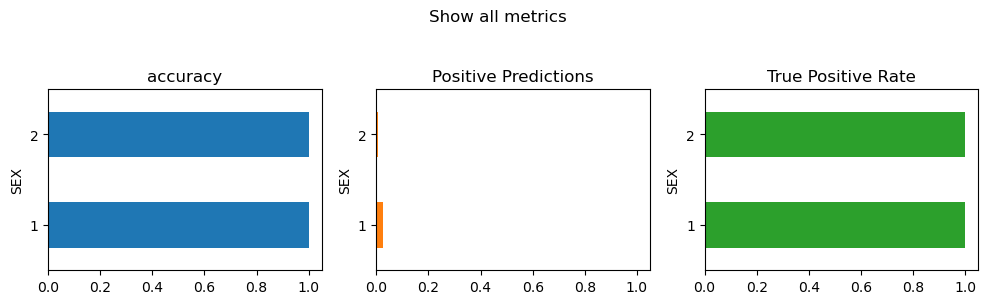

In [152]:
metrics = {
    "accuracy": accuracy_score,
    "Positive Predictions": pos_pred,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=data_transf_test.labels, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

**3) Reweighting Instances:** Reweighting preprocessing methods are techniques designed to address fairness concerns in machine learning by adjusting the importance or weight assigned to different instances in the training dataset. These methods aim to mitigate bias and ensure that the model provides fair predictions across different groups. 

In [153]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

In [154]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [155]:
data_train=X_train.copy()
data_train['sex']=group_train.copy()
data_train['target']=y_train.copy()
privileged_groups = [{'sex': 2}]
unprivileged_groups = [{'sex': 1}]

binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_train,
    label_names=['target'],
    protected_attribute_names=['sex'])


RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(binaryLabelDataset)
data_transf_train = RW.transform(binaryLabelDataset)

In [156]:
data_transf_train.feature_names

['AGEP',
 'SCHL',
 'MAR',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'RAC1P',
 'PUMA',
 'OCCP',
 'JWTR',
 'GCL',
 'PINCP',
 'ESR',
 'OCCP',
 'POWPUMA',
 'sex']

In [157]:
classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(data_transf_train.features[:,:-1], data_transf_train.labels,
               sample_weight=data_transf_train.instance_weights)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=5)

#### Now, let's test our model. But, first remember to transform our test data also

In [158]:
data_test=X_test.copy()
data_test['sex']=group_test.copy()
data_test['target']=y_test.copy()

binaryLabel_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_test,
    label_names=['target'],
    protected_attribute_names=['sex'])

data_transf_test = RW.transform(binaryLabel_test)

In [159]:
y_pred = classifier.predict(data_transf_test.features[:,:-1])

2487
1303
1184


array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'Positive Predictions'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

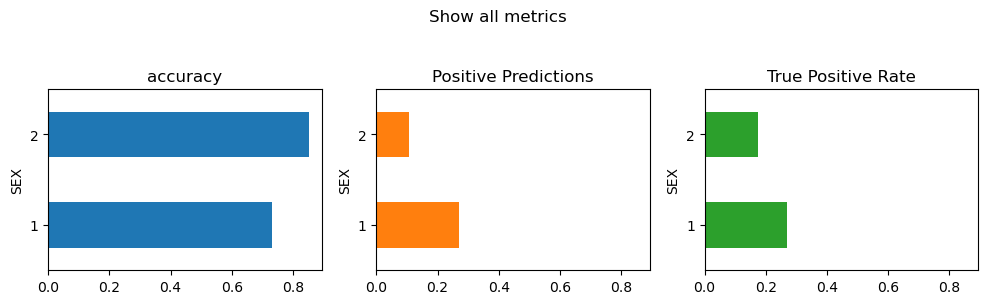

In [160]:
metrics = {
    "accuracy": accuracy_score,
    "Positive Predictions": pos_pred,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=data_transf_test.labels, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### References

- Bellamy, R. K., Dey, K., Hind, M., Hoffman, S. C., Houde, S., Kannan, K., ... & Zhang, Y. (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv preprint arXiv:1810.01943.

- R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork, “Learning Fair Representations.” International Conference on Machine Learning, 2013.

- F. Kamiran and T. Calders, “Data Preprocessing Techniques for Classification without Discrimination,” Knowledge and Information Systems, 2012.

- Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A python toolbox to tackle the curse of imbalanced datasets in machine learning. The Journal of Machine Learning Research, 18(1), 559-563.